In [1]:
#import some necessary libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
train_df = pd.read_json('input/train.json')
test_df = pd.read_json('input/test.json')
train_df.shape, test_df.shape

((39774, 3), (9944, 2))

In [3]:
train_df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [9]:
test_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [5]:
ingredients_counter = Counter()
for ingredients in train_df['ingredients']:
    ingredients_counter.update(ingredients)
len(ingredients_counter)

6714

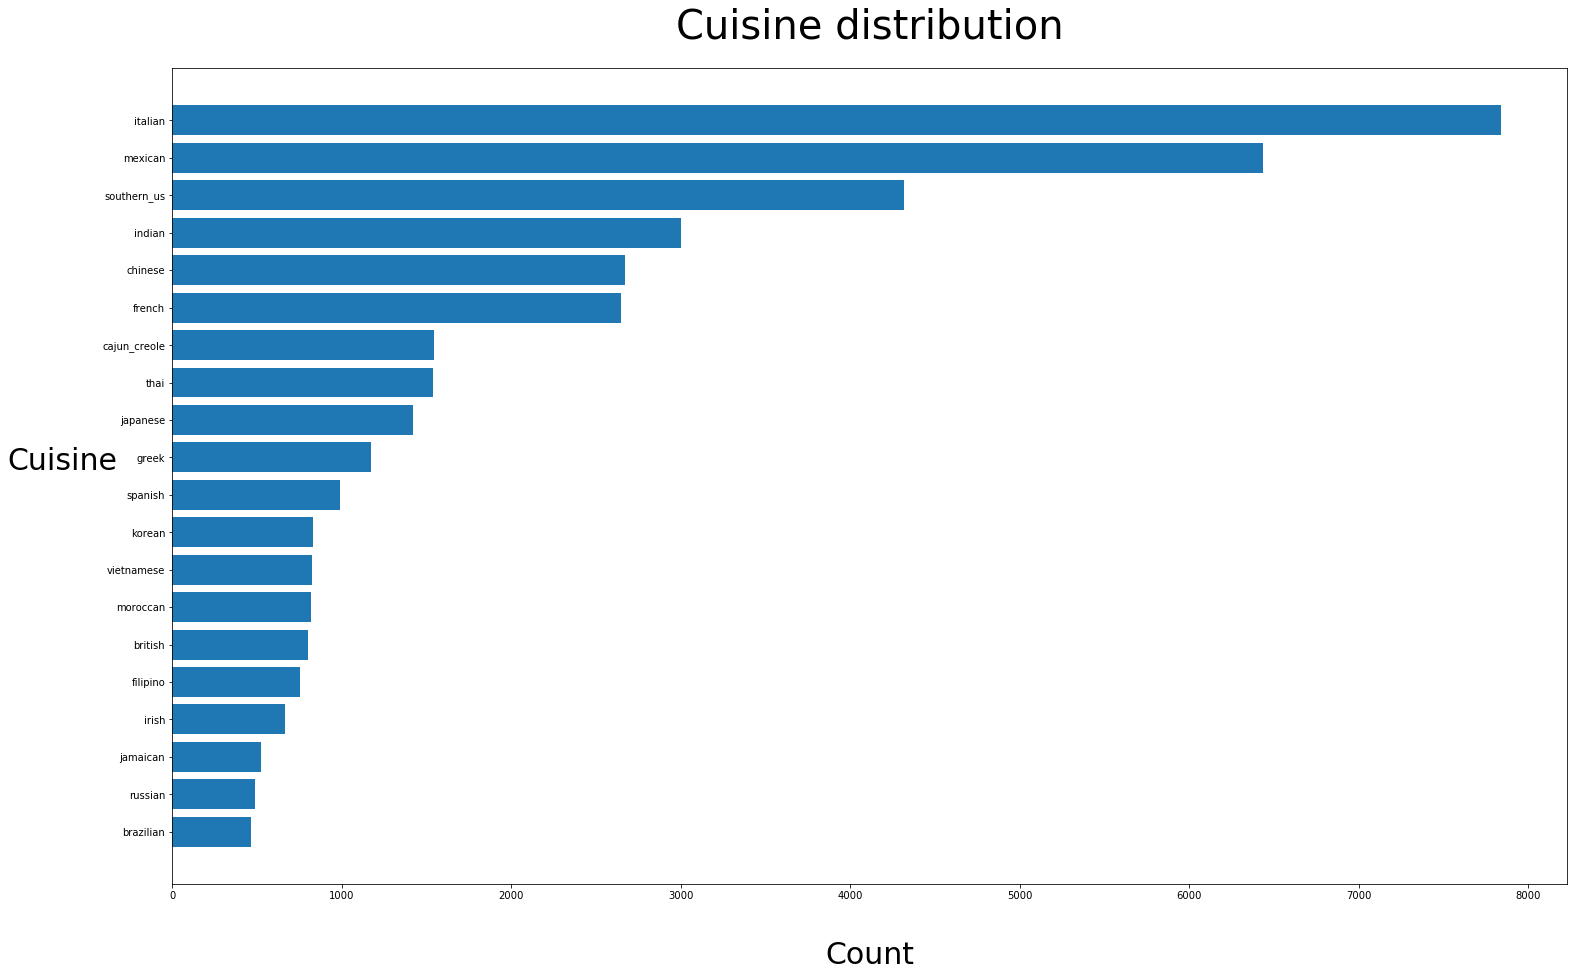

In [6]:
categories_count = train_df.groupby(['cuisine']).size().sort_values(ascending=False)
# categories_count.plot.barh(title='Cuisine distribution', figsize=(10,10), fontsize=15)
# plt.xlabel('Count', fontsize=18)
# plt.ylabel('')
# plt.show()
keys = list(categories_count.keys())
values = [categories_count[key] for key in keys]
plt.figure(figsize=(25,15))
ax = plt.gca()
y_pos = np.arange(len(keys))
ttl = ax.title
ttl.set_position([.5, 1.03])
ax.barh(range(len(keys)), values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.invert_yaxis()
plt.title('Cuisine distribution', fontsize=40)
plt.xlabel('Count', fontsize=30, labelpad=40)
plt.ylabel('Cuisine', fontsize=30, rotation=0, labelpad=40)
# plt.barh(range(len(keys)), height=values)
# plt.xticks(range(len(keys)),keys)
plt.show()

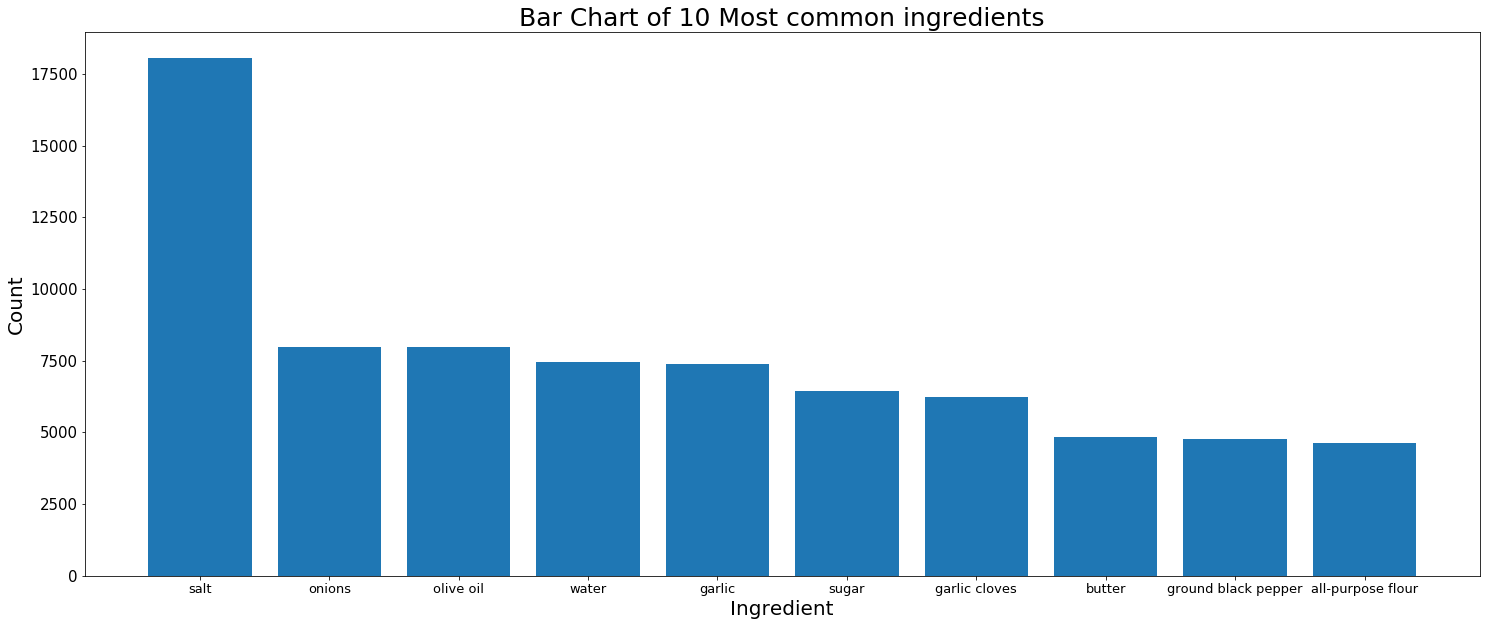

In [7]:
most_common_10_gradients = ingredients_counter.most_common(10)
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 15

plt.figure(figsize=(25,10))
plt.bar(range(10), [ingredient[1] for ingredient in most_common_10_gradients], align='center')
plt.xticks(range(10), [ingredient[0] for ingredient in most_common_10_gradients])
plt.xlabel('Ingredient', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Bar Chart of 10 Most common ingredients', fontsize=25)
plt.show()

In [8]:
ingredients_index = {ingredient[0]: index for index, ingredient in enumerate(most_common_100_gredients)}
trainX = []
trainY = []
for index, record in train_df.iterrows():
    trainY.append(record['cuisine'])
    temp = np.zeros(100)
    for ingredient in record['ingredients']:
        if ingredient in ingredients_index:
            temp[ingredients_index[ingredient]] = 1
    trainX.append(temp)
print(trainX[:2])
print(trainY[:2])

NameError: name 'most_common_100_gredients' is not defined

In [ ]:
train_df.info()

In [ ]:
print(1)